# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def fmt_items(lines,max_lines=0):
    max_width=max([len(line)for line in lines])
    empty =' '*max_width
    lines = [line.ljust(max_width)for line in lines]
    lines += [empty]*(max_lines - len(lines))
    return lines
    
def pp (*list):
    lines = [ str(item).split('\n') for item in list]
    max_lines=max([len(item)for  item in lines])
    lines = [fmt_items(item,max_lines=max_lines)for item in lines]
    lines_t= np.array(lines).T
    print('\n'.join([' '.join(line) for  line in lines_t]))


In [2]:
%matplotlib nbagg

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [4]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [5]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

==GRAD_CHECK== at (0,)  num = 6.000000000039306 anal = 6.0
Gradient check passed!
==GRAD_CHECK== at (0,)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (1,)  num = 1.0000000000065512 anal = 1.0
Gradient check passed!
==GRAD_CHECK== at (0, 0)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (0, 1)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (1, 0)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (1, 1)  num = 1.0000000000065512 anal = 1.0
Gradient check passed!


True

In [6]:
(array_sum(np.array([5.0, 2.0]))[0]-array_sum(np.array([1.0, 2.0]))[0])/4

1.0

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [7]:
import linear_classifer 
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))
print(probs)
# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
print(probs)
# assert np.isclose(probs[0], 1.0)

[2.06106005e-09 4.53978686e-05 9.99954600e-01]
[1. 0. 0.]


Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [8]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
    
linear_classifer.cross_entropy_loss(probs, np.array(2))


IndexError: too many indices for array

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [ ]:
probs = linear_classifer.softmax(np.array([1, 0, 0]))
linear_classifer.cross_entropy_loss(probs, 0)

In [9]:
loss, grad= linear_classifer.softmax_with_cross_entropy(np.array([1., 0., 0.]), 0)
loss1, grad1= linear_classifer.softmax_with_cross_entropy(np.array([3, 0, 0]), 0)
loss2, grad2 = linear_classifer.softmax_with_cross_entropy(np.array([-1, 0, 0]), 0)
print((loss1-loss2)/4)
print('loss,grad = ',loss, grad)

enter of the function =  [1. 0. 0.] 0
soft max = [0.57611688 0.21194156 0.21194156]


AttributeError: 'int' object has no attribute 'flatten'

In [22]:
# TODO Implement combined function orsoftmax and cross entropy and produces gradient #-2.0491237621641485

check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([ 1,0,0], np.float))

enter of the function =  [1. 0. 0.] 1


AttributeError: 'int' object has no attribute 'flatten'

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [9]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
pp('predictions =',predictions)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
pp('targets = ',target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
print('predictions =',predictions)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
print('targets = ',target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

predictions = [[ 1.  2. -1.  1.]]
targets =  [[2]]
log loss =  3.5797242232074917
log loss =  3.5797283438783922
log loss =  3.5797201026020242
==GRAD_CHECK== at (0, 0)  num = 0.20603190920009948 anal = 0.20603190919001857
log loss =  3.579735424312667
log loss =  3.5797130222008735
==GRAD_CHECK== at (0, 1)  num = 0.5600527948401712 anal = 0.5600527948339517
log loss =  3.5797047808806486
log loss =  3.5797436655451773
==GRAD_CHECK== at (0, 2)  num = -0.9721166132181657 anal = -0.9721166132139888
log loss =  3.5797283438783922
log loss =  3.5797201026020242
==GRAD_CHECK== at (0, 3)  num = 0.20603190920009948 anal = 0.20603190919001857
Gradient check passed!
predictions = [[ 2. -1. -1.  1.]
 [ 0.  1.  1.  1.]
 [ 1.  2. -1.  2.]]
targets =  [[3]
 [3]
 [2]]
log loss =  9.901861007689417
log loss =  9.901872717171424
log loss =  9.901849298395895
==GRAD_CHECK== at (0, 0)  num = 0.19515646273449147 anal = 0.19515646271894127
log loss =  9.901861590671281
log loss =  9.901860424719102
==GRAD

True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [10]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)


loss, dW = linear_classifer.linear_softmax(X, W, target_index)
pp(dW)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

log loss =  4.370364905207625
[[-0.11245721  0.48478057] 
 [-0.07108652  0.81573323] 
 [ 0.15382791 -0.15382791]]
log loss =  4.370364905207625
log loss =  4.370360406959003
log loss =  4.370369403536097
==GRAD_CHECK== at (0, 0)  num = -0.11245721367458826 anal = -0.11245721367093255
log loss =  4.370384296436465
log loss =  4.370345513990775
==GRAD_CHECK== at (0, 1)  num = 0.4847805711305497 anal = 0.48478057113584405
log loss =  4.370362061806466
log loss =  4.370367748727805
==GRAD_CHECK== at (1, 0)  num = -0.07108651673970456 anal = -0.0710865167499724
log loss =  4.370397534609193
log loss =  4.370332275950659
==GRAD_CHECK== at (1, 1)  num = 0.8157332316738318 anal = 0.8157332316797954
log loss =  4.370371058376115
log loss =  4.370358752143268
==GRAD_CHECK== at (2, 0)  num = 0.15382791058726752 anal = 0.15382791059189269
log loss =  4.370358752143268
log loss =  4.370371058376115
==GRAD_CHECK== at (2, 1)  num = -0.15382791058726752 anal = -0.1538279105918927
Gradient check passed

True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [11]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

==GRAD_CHECK== at (0, 0)  num = 0.009999999999940612 anal = 0.01
==GRAD_CHECK== at (0, 1)  num = 0.02000000000022817 anal = 0.02
==GRAD_CHECK== at (1, 0)  num = -0.009999999999940612 anal = -0.01
==GRAD_CHECK== at (1, 1)  num = 0.009999999999940612 anal = 0.01
==GRAD_CHECK== at (2, 0)  num = 0.009999999999940612 anal = 0.01
==GRAD_CHECK== at (2, 1)  num = 0.02000000000022817 anal = 0.02
Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [12]:
# TODO: Implement LinearSoftmaxClassifier.fit function 
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)
'''THERE WERE 10 EPOCHS   !!!!!
'''

log loss =  102671.3413754061
Epoch 0, loss: 11.438614
== W == 0.015367261325207056
log loss =  102670.96466120379
Epoch 1, loss: 11.437961
== W == 0.015085558438602847
log loss =  102670.5928852757
Epoch 2, loss: 11.437320
== W == 0.014808943099298658
log loss =  102670.2259652477
Epoch 3, loss: 11.436692
== W == 0.014537309014583003
log loss =  102669.86382058142
Epoch 4, loss: 11.436077
== W == 0.014270552564537253
log loss =  102669.50637252312
Epoch 5, loss: 11.435473
== W == 0.014008572722868672
log loss =  102669.15354405412
Epoch 6, loss: 11.434881
== W == 0.01375127098036174
log loss =  102668.80525984285
Epoch 7, loss: 11.434301
== W == 0.013498551270855093
log loss =  102668.46144619831
Epoch 8, loss: 11.433732
== W == 0.013250319899654427
log loss =  102668.12203102512
Epoch 9, loss: 11.433174
== W == 0.01300648547429593


'THERE WERE 10 EPOCHS   !!!!!\n'

[11.438613883758585, 11.43796059130765, 11.437320100386984, 11.436692156753265, 11.436076511269762, 11.435472919802418, 11.434881143118098, 11.434300946784926, 11.433732101074703, 11.433174380867348]


<IPython.core.display.Javascript object>


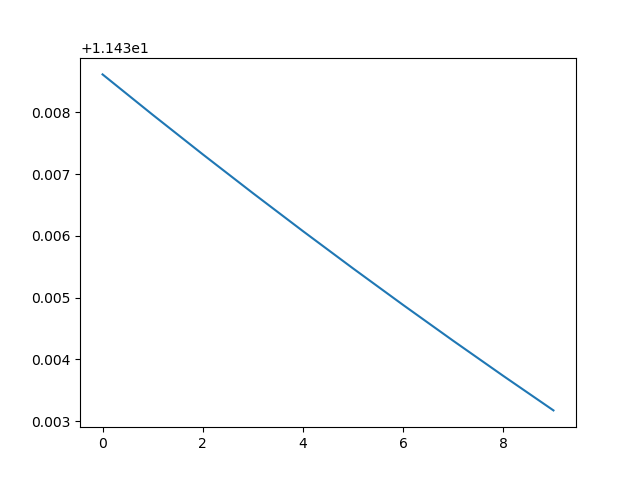

In [13]:
# let's look at the loss history!
print(loss_history)
plt.plot(loss_history)

In [12]:
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=300, learning_rate=1e-2, batch_size=300, reg=1e1)

log loss =  102672.22223537287
Epoch 0, loss: 11.438938
== W == -0.13850988143941917
log loss =  102668.01209231211
Epoch 1, loss: 11.432590
== W == -0.11593693684367773
log loss =  102664.43328211678
Epoch 2, loss: 11.427439
== W == -0.09706479861409674
log loss =  102661.36464946879
Epoch 3, loss: 11.423255
== W == -0.08130332752582703
log loss =  102658.7140103868
Epoch 4, loss: 11.419854
== W == -0.06814998101814351
log loss =  102656.4102012468
Epoch 5, loss: 11.417087
== W == -0.057179111444244486
log loss =  102654.39746755142
Epoch 6, loss: 11.414834
== W == -0.048031723963828786
log loss =  102652.63148050304
Epoch 7, loss: 11.412998
== W == -0.040406052313938345
log loss =  102651.07648991379
Epoch 8, loss: 11.411500
== W == -0.03404911030153338
log loss =  102649.70327336344
Epoch 9, loss: 11.410278
== W == -0.028749255254630818
log loss =  102648.48764570677
Epoch 10, loss: 11.409278
== W == -0.02432972897702787
log loss =  102647.40936488977
Epoch 11, loss: 11.408461
== W 

Epoch 94, loss: 11.404585
== W == -0.0014929819171630634
log loss =  102638.38422528199
Epoch 95, loss: 11.404585
== W == -0.001492940413060538
log loss =  102638.38411685431
Epoch 96, loss: 11.404585
== W == -0.0014929032735352097
log loss =  102638.38401941305
Epoch 97, loss: 11.404585
== W == -0.0014928700379133687
log loss =  102638.38393184464
Epoch 98, loss: 11.404585
== W == -0.001492840294421382
log loss =  102638.3838531485
Epoch 99, loss: 11.404585
== W == -0.0014928136749485922
log loss =  102638.38378242552
Epoch 100, loss: 11.404585
== W == -0.0014927898503789704
log loss =  102638.38371886764
Epoch 101, loss: 11.404585
== W == -0.001492768526428418
log loss =  102638.3836617488
Epoch 102, loss: 11.404585
== W == -0.001492749439931902
log loss =  102638.38361041652
Epoch 103, loss: 11.404585
== W == -0.0014927323555307544
log loss =  102638.38356428439
Epoch 104, loss: 11.404585
== W == -0.0014927170627164058
log loss =  102638.38352282552
Epoch 105, loss: 11.404585
== W =

== W == -0.0014925862753377539
log loss =  102638.38315497649
Epoch 188, loss: 11.404585
== W == -0.0014925862738694611
log loss =  102638.3831549712
Epoch 189, loss: 11.404585
== W == -0.0014925862725536534
log loss =  102638.3831549664
Epoch 190, loss: 11.404585
== W == -0.0014925862713744693
log loss =  102638.38315496212
Epoch 191, loss: 11.404585
== W == -0.0014925862703177202
log loss =  102638.38315495827
Epoch 192, loss: 11.404585
== W == -0.0014925862693706778
log loss =  102638.3831549548
Epoch 193, loss: 11.404585
== W == -0.0014925862685219544
log loss =  102638.38315495169
Epoch 194, loss: 11.404585
== W == -0.0014925862677613233
log loss =  102638.38315494888
Epoch 195, loss: 11.404585
== W == -0.001492586267079639
log loss =  102638.38315494636
Epoch 196, loss: 11.404585
== W == -0.0014925862664687019
log loss =  102638.38315494411
Epoch 197, loss: 11.404585
== W == -0.001492586265921163
log loss =  102638.38315494207
Epoch 198, loss: 11.404585
== W == -0.001492586265430

Epoch 280, loss: 11.404585
== W == -0.0014925862611877472
log loss =  102638.383154924
Epoch 281, loss: 11.404585
== W == -0.0014925862611876884
log loss =  102638.383154924
Epoch 282, loss: 11.404585
== W == -0.0014925862611876429
log loss =  102638.383154924
Epoch 283, loss: 11.404585
== W == -0.0014925862611875865
log loss =  102638.383154924
Epoch 284, loss: 11.404585
== W == -0.0014925862611875462
log loss =  102638.383154924
Epoch 285, loss: 11.404585
== W == -0.0014925862611875162
log loss =  102638.383154924
Epoch 286, loss: 11.404585
== W == -0.0014925862611874835
log loss =  102638.383154924
Epoch 287, loss: 11.404585
== W == -0.0014925862611874516
log loss =  102638.383154924
Epoch 288, loss: 11.404585
== W == -0.0014925862611874297
log loss =  102638.383154924
Epoch 289, loss: 11.404585
== W == -0.0014925862611874121
log loss =  102638.383154924
Epoch 290, loss: 11.404585
== W == -0.0014925862611873885
log loss =  102638.383154924
Epoch 291, loss: 11.404585
== W == -0.00149

[11.438937692796957, 11.432590312134229, 11.427439193476811, 11.423255348907151, 11.419854315178924, 11.41708732585098, 11.414834281223714, 11.4129981361184, 11.411500409888163, 11.410277587506208, 11.409278230163812, 11.408460652188333, 11.407791050955707, 11.407241999825374, 11.406791232468736, 11.406420661426571, 11.406115585177456, 11.405864047085423, 11.4056563168281, 11.405484470678072, 11.405342051625405, 11.40522379402661, 11.405125400432437, 11.405043360630867, 11.404974804859863, 11.404917384689417, 11.404869176317659, 11.404828602030662, 11.404794366386714, 11.404765404341102, 11.404740839057078, 11.404719947577052, 11.40470213287433, 11.40468690108626, 11.404673842956532, 11.40466261869816, 11.404652945637537, 11.40464458812062, 11.404637349259943, 11.404631064180494, 11.404625594486614, 11.404620823724269, 11.404616653655221, 11.404613001193997, 11.404609795886252, 11.404606977829856, 11.404604495958267, 11.404602306620697, 11.404600372405675, 11.404598661164451, 11.404597

(10, 12)

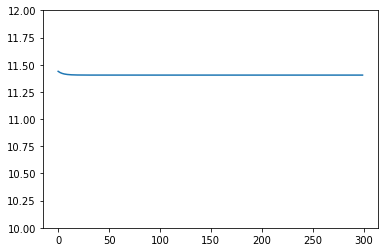

In [13]:
print(loss_history)
plt.plot(loss_history)
plt.gca().set_ylim(10,12)

log loss =  102666.87725276875
Epoch 0, loss: 11.407741
== W == -0.01390425673879591
log loss =  102635.62868256599
Epoch 1, loss: 11.404266
== W == -0.014696236482090501
log loss =  102609.12616507155
Epoch 2, loss: 11.401325
== W == -0.019762657927254425
log loss =  102583.94347242975
Epoch 3, loss: 11.398536
== W == -0.023813950404609822
log loss =  102559.73432609449
Epoch 4, loss: 11.395859
== W == -0.026891847901103515
log loss =  102536.41494446977
Epoch 5, loss: 11.393287
== W == -0.02960667364279406
log loss =  102513.92986494373
Epoch 6, loss: 11.390811
== W == -0.03230519669735479
log loss =  102492.23084783637
Epoch 7, loss: 11.388427
== W == -0.03512284338523583
log loss =  102471.27426866804
Epoch 8, loss: 11.386129
== W == -0.03809530370989363
log loss =  102451.02036487067
Epoch 9, loss: 11.383912
== W == -0.041219714214467205
log loss =  102431.43276341555
Epoch 0, loss: 11.381773
== W == -0.04448063756718057
log loss =  102412.4780984489
Epoch 1, loss: 11.379707
== W 

log loss =  101784.7247386067
Epoch 7, loss: 11.314749
== W == -0.27131768823495517
log loss =  101782.38333166722
Epoch 8, loss: 11.314525
== W == -0.27249997777681645
log loss =  101780.08714054967
Epoch 9, loss: 11.314306
== W == -0.2736603040219965
log loss =  101777.83514074289
Epoch 0, loss: 11.314092
== W == -0.27479905908827396
log loss =  101775.62633516316
Epoch 1, loss: 11.313881
== W == -0.2759166295808292
log loss =  101773.45975329829
Epoch 2, loss: 11.313675
== W == -0.2770133965934479
log loss =  101771.33445038169
Epoch 3, loss: 11.313473
== W == -0.27808973571407264
log loss =  101769.24950659538
Epoch 4, loss: 11.313275
== W == -0.27914601703442476
log loss =  101767.20402630113
Epoch 5, loss: 11.313081
== W == -0.2801826051634619
log loss =  101765.19713729803
Epoch 6, loss: 11.312890
== W == -0.2811998592444332
log loss =  101763.22799010629
Epoch 7, loss: 11.312703
== W == -0.2821981329753246
log loss =  101761.29575727541
Epoch 8, loss: 11.312520
== W == -0.28317

Epoch 5, loss: 11.304610
== W == -0.32495573941129285
log loss =  101675.76216017907
Epoch 6, loss: 11.304570
== W == -0.3251513566376131
log loss =  101675.33332403957
Epoch 7, loss: 11.304531
== W == -0.3253436110593829
log loss =  101674.91104836401
Epoch 8, loss: 11.304493
== W == -0.3255325652730048
log loss =  101674.49522226512
Epoch 9, loss: 11.304455
== W == -0.3257182806311871
log loss =  101674.0857369498
Epoch 0, loss: 11.304417
== W == -0.32590081726840425
log loss =  101673.68248567473
Epoch 1, loss: 11.304381
== W == -0.3260802341258505
log loss =  101673.28536370273
Epoch 2, loss: 11.304345
== W == -0.3262565889759045
log loss =  101672.89426826057
Epoch 3, loss: 11.304309
== W == -0.326429938446104
log loss =  101672.50909849741
Epoch 4, loss: 11.304274
== W == -0.32660033804264754
log loss =  101672.12975544449
Epoch 5, loss: 11.304240
== W == -0.32676784217342253
log loss =  101671.75614197567
Epoch 6, loss: 11.304206
== W == -0.3269325041705742
log loss =  101671.38

log loss =  101653.52835358985
Epoch 3, loss: 11.302559
== W == -0.3344732778123159
log loss =  101653.42257502851
Epoch 4, loss: 11.302550
== W == -0.33451317214384324
log loss =  101653.31822706653
Epoch 5, loss: 11.302541
== W == -0.33455246273262595
log loss =  101653.21528898734
Epoch 6, loss: 11.302531
== W == -0.3345911593311043
log loss =  101653.11374039987
Epoch 7, loss: 11.302522
== W == -0.3346292715212805
log loss =  101653.013561233
Epoch 8, loss: 11.302513
== W == -0.3346668087179572
log loss =  101652.91473173004
Epoch 9, loss: 11.302504
== W == -0.33470378017190616
   learn rate  regul  acc_val  acc_train
0         0.1    0.1    0.233      0.233


<IPython.core.display.Javascript object>


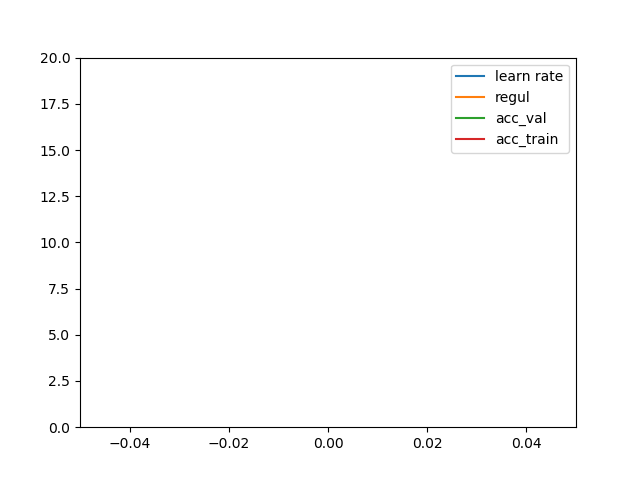

(0, 20)

In [77]:
num_epochs = 300
batch_size = 300

learning_rates = [1e-1]
reg_strengths = [1e-1]

best_classifier = None
best_val_accuracy = None

data:list = list()
train_val:list = list()

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
   
for l in learning_rates:
    for r in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        for i in range(0,num_epochs,10): 
            classifier.fit(train_X, train_y, epochs=10, learning_rate=l, batch_size=300, reg=r)
            pred_val = classifier.predict(val_X)
            pred_train = classifier.predict(train_X)
            accuracy_val = multiclass_accuracy(pred_val, val_y)
            accuracy_train = multiclass_accuracy(pred_train, train_y)
            train_val.append({'acc_val':accuracy_val,'acc_train':accuracy_val})
        data.append({'learn rate':l,'regul':r,'acc_val':accuracy_val,'acc_train':accuracy_val})
        


frame = pd.DataFrame(data)
tr_val = pd.DataFrame(train_val)
print(frame)
frame.plot()
axes = plt.gca()
axes.set_ylim(0,20)

# print('best validation accuracy achieved: %f' % best_val_accuracy)

<IPython.core.display.Javascript object>


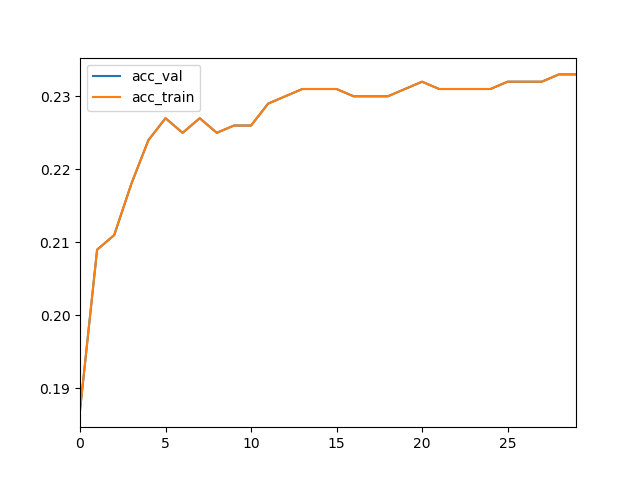

    acc_val  acc_train
0     0.187      0.187
1     0.209      0.209
2     0.211      0.211
3     0.218      0.218
4     0.224      0.224
5     0.227      0.227
6     0.225      0.225
7     0.227      0.227
8     0.225      0.225
9     0.226      0.226
10    0.226      0.226
11    0.229      0.229
12    0.230      0.230
13    0.231      0.231
14    0.231      0.231
15    0.231      0.231
16    0.230      0.230
17    0.230      0.230
18    0.230      0.230
19    0.231      0.231
20    0.232      0.232
21    0.231      0.231
22    0.231      0.231
23    0.231      0.231
24    0.231      0.231
25    0.232      0.232
26    0.232      0.232
27    0.232      0.232
28    0.233      0.233
29    0.233      0.233


In [78]:
tr_val=pd.DataFrame(train_val)
# plt.plot(tr_val['acc_val'])
# plt.plot(tr_val['acc_train'])
tr_val.plot()
print(tr_val)

<IPython.core.display.Javascript object>


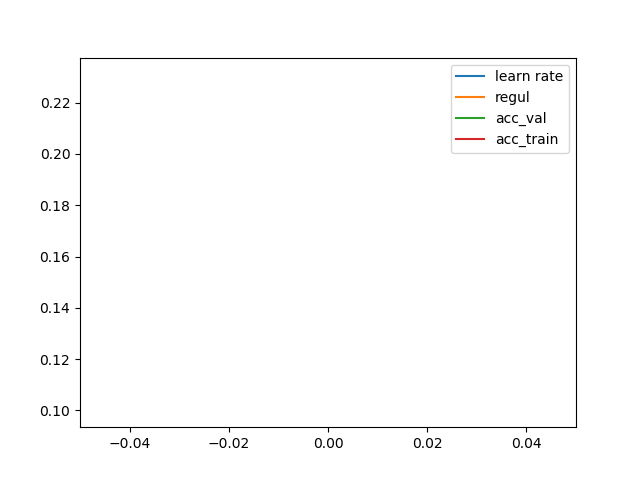

In [47]:
frame.plot()

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

   learn rate  regul  acc_val  acc_train
0         0.1    0.1     0.23       0.23


<IPython.core.display.Javascript object>


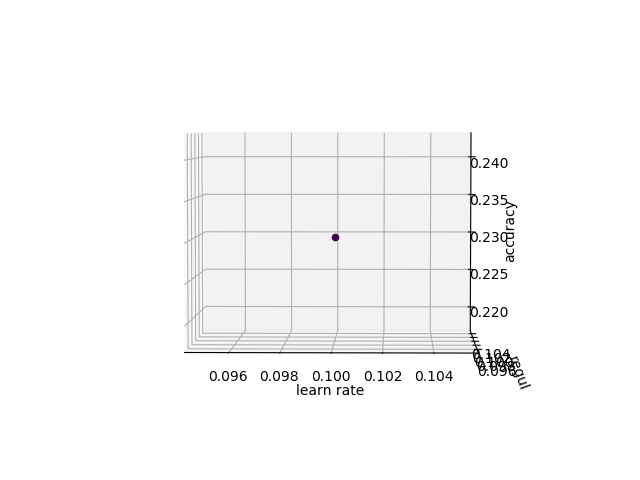

Text(0.5, 0, 'accuracy')

In [69]:
print(frame)
ax=plt.subplot(projection = '3d')
ax.scatter(frame['learn rate'],frame['regul'],frame['acc_val'],c = frame['acc_val'],cmap = 'viridis')
ax.set_xlabel('learn rate')
ax.set_ylabel('regul')
ax.set_zlabel('accuracy')

   learn rate  regul  acc_val  acc_train
0         0.1    0.1    0.231      0.231


TypeError: scatter() missing 1 required positional argument: 'y'

   learn rate  regul  acc_val  acc_train
0         0.1    0.1    0.231      0.231


<IPython.core.display.Javascript object>


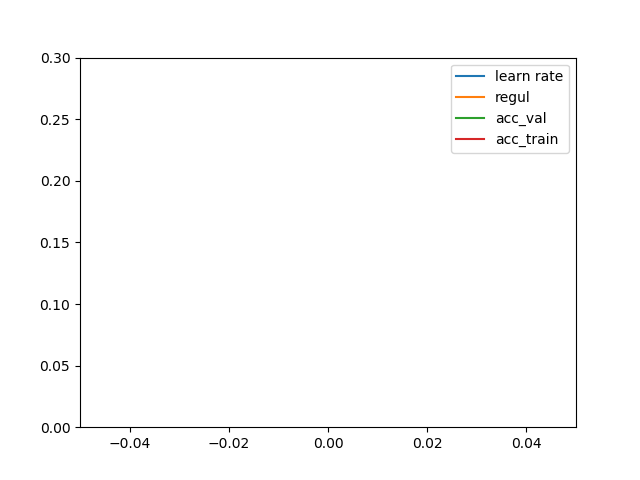

(0, 0.3)

In [56]:
print(frame)
frame.plot()
axes = plt.gca()
axes.set_ylim(0,0.3)

In [73]:
test_class = linear_classifer.LinearSoftmaxClassifier()
test_pred = test_class.pred_rand(val_X)
accuracy = multiclass_accuracy(test_pred, val_y)
print(accuracy)

0.114


# Какой же точности мы добились на тестовых данных?

In [79]:


test_pred = classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.203000


In [18]:
np.__version__

'1.17.0'